In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip -q data.zip
!rm data.zip

--2020-04-17 03:44:46--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.45.116, 13.226.45.86, 13.226.45.16, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.45.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  2.15MB/s    in 1.3s    

2020-04-17 03:44:48 (2.15 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [0]:
import unicodedata 
import re 
import random 
import string 

import torch.nn as nn 
import torch 
import torch.optim as optim 
import torch.nn.functional as F 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
SOS_token = 0 
EOS_token = 1 

class Language:
  def __init__(self, name):
    self.word2int = {}
    self.word2count = {}
    self.int2word = {0: 'SOS', 1: 'EOS'}
    self.n_words = 2
  
  def addSentence(self, sentence):
    for word in sentence.split():
      self.addWord(word)

  def addWord(self, word):
    if word not in self.word2int:
      self.word2int[word] = self.n_words
      self.word2count[word] = 1 
      self.int2word[self.n_words] = word
      self.n_words += 1 
    else:
      self.word2count[word] += 1

In [0]:
def UnicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
  )

def normalizeData(s):
  s = UnicodeToAscii(s.lower().strip())
  s = re.sub(r'([.!?])', r' \1', s)
  s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
  return s 

In [5]:
test = "Hello i'm Cong Dao ."
normalizeData(test)

'hello i m cong dao .'

In [0]:
def readLanguage(lang1, lang2, reverse=False):
  print('Reading lines...')
  lines = open('./data/eng-fra.txt', encoding='utf8').\
        read().strip().split('\n')
  
  pairs = [[normalizeData(s) for s in l.split('\t')] for l in lines]
  
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Language(lang2)
    output_lang = Language(lang1)
  else:
    input_lang = Language(lang1)
    output_lang = Language(lang2)
  
  return input_lang, output_lang, pairs 

In [0]:
MAX_LENGTH = 10 
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
  return len(p[0].split()) < MAX_LENGTH and\
          len(p[1].split()) < MAX_LENGTH and\
          p[1].startswith(eng_prefixes)

def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]

In [8]:
l = "I'm fat.	Je suis gras."
pairs = [[normalizeData(s) for s in l.split('\t')]]
print(filterPair(pairs[0]))

False


In [9]:
def prepareData(lang1, lang2):
  input_lang, output_lang, pairs = readLanguage(lang1, lang2, reverse=True)
  print("Read %d sentence pairs." %len(pairs))
  pairs = filterPairs(pairs)
  print("Trimmed %d sentence pairs." %len(pairs))

  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print("Length %s language vocab : %d." %(lang1, input_lang.n_words))
  print("Length %s language vocab : %d." %(lang2, output_lang.n_words))

  return input_lang, output_lang, pairs 

lang1 = "fra"
lang2 = "eng"
input_lang, output_lang, pairs = prepareData(lang1, lang2)

Reading lines...
Read 135842 sentence pairs.
Trimmed 10599 sentence pairs.
Length fra language vocab : 4345.
Length eng language vocab : 2803.


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device))

In [0]:
# Preparing training data
def indexesFromSentence(lang, sentence):
  return [lang.word2int[w] for w in sentence.split()]

def tensorFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device)

def tensorsFromPair(pair):
  input_tensor = tensorFromSentence(input_lang, pair[0])
  target_tensor = tensorFromSentence(output_lang, pair[1]).view(-1, 1)
  return input_tensor, target_tensor 

In [0]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
  encoder_hidden = encoder.initHidden()
  
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)
  encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
  
  loss = 0 

  for i in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
    encoder_outputs[i] = encoder_output[0, 0]
    
  decoder_input = torch.tensor([[SOS_token]], device=device)
  decoder_hidden = encoder_hidden 

  use_teacher_forcing = True if random.random() > teacher_forcing_ratio else False
  if use_teacher_forcing:
    # Teacher forcing: feed the target as the next input 
    for i in range(target_length):
      decoder_output, decoder_hidden, _ = decoder(decoder_input, 
                                               decoder_hidden, encoder_outputs)
      loss += criterion(decoder_output, target_tensor[i])
      decoder_input = target_tensor[i]
  else:
    # Without teacher forcing: use its own predictions as the next input 
    for i in range(target_length):
      decoder_output, decoder_hidden, _ = decoder(decoder_input, 
                                               decoder_hidden, encoder_outputs)
      loss += criterion(decoder_output, target_tensor[i])

      top_n, top_i = decoder_output.topk(1)
      decoder_input = top_i.squeeze().detach()
      if decoder_input.item() == EOS_token:
        break
  
  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()
  return loss.item() / target_length

In [0]:
def timeSince(since):
  now = time.time()
  s = now - since 
  m = s // 60 
  s -= m*60 
  return " %dm %ds " %(m, s)

In [0]:
import matplotlib.pyplot as plt
import time 

def showPlot(losses):
  plt.figure()
  plt.plot(losses)

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):

  start = time.time()
  plot_losses = []
  print_loss_total = 0 
  plot_loss_total = 0 

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

  criterion = nn.NLLLoss()
  training_pairs = [tensorsFromPair(random.choice(pairs)) 
                    for i in range(n_iters)]
  for iter in range(1, n_iters + 1):
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
                 decoder_optimizer, criterion)
    print_loss_total += loss 
    plot_loss_total += loss 
    
    if iter % print_every == 0:
      print_loss_avg = print_loss_total / print_every 
      print("%s (%d %d%%) %.4f" %(timeSince(start), iter, iter*100/n_iters, print_loss_avg))
      print_loss_total = 0 
      evaluateRandomly(encoder, decoder, n=5)
    
    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every 
      plot_losses.append(plot_loss_avg)
      plot_loss_total = 0
  
  showPlot(plot_losses)
    

In [0]:
def evaluate(encoder, decoder , sentence, max_length=MAX_LENGTH):
  with torch.no_grad():
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    input_tensor = tensorFromSentence(input_lang, sentence)
    input_length = input_tensor.size(0)
    encoder_hidden = encoder.initHidden()
    
    for i in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
      encoder_outputs[i] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)
    decoder_hidden = encoder_hidden 
    results = []
    decoder_attentions = torch.zeros(max_length, max_length)
    for i in range(max_length):
      decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
      decoder_attentions[i] = attn_weights.data
      top_n, top_i = decoder_output.topk(1)
      pred_id = top_i.item()
      if pred_id == EOS_token:
        results.append('<EOS>')
        break
      results.append(output_lang.int2word[pred_id])
      decoder_input = top_i.squeeze().detach()
    
    return results, decoder_attentions

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
  for i in range(n):
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    results, _ = evaluate(encoder, decoder, pair[0])
    print('< ', ' '.join(results)) 
    print('')

 0m 31s  (1000 1%) 3.4629
> j ai peur de l obscurite .
= i m afraid of the dark .
<  i m not to of . <EOS>

> vous etes trop polies .
= you re too polite .
<  we are a a . . <EOS>

> nous sommes tous impressionnes .
= we re all impressed .
<  we are a a . . <EOS>

> je suis quelqu un de bien .
= i m a nice guy .
<  i m not to of . <EOS>

> tu dois faire comme je te dis .
= you are to do as i tell you .
<  i m not to the you . <EOS>

 0m 55s  (2000 2%) 2.8918
> c est un critique gastronomique .
= he s a food critic .
<  he s a a to . . <EOS>

> elles s amusent .
= they re enjoying themselves .
<  they re all . <EOS>

> vous etes odieuse .
= you re obnoxious .
<  you re very . <EOS>

> j ai froid .
= i m cold .
<  i m all . <EOS>

> tu es cruelle .
= you re cruel .
<  you re all . <EOS>

 1m 20s  (3000 4%) 2.7409
> je suis certain qu elle va bientot surgir .
= i m sure she will turn up soon .
<  i m not going to . . . <EOS>

> nous sommes tous des laches .
= we re all cowards .
<  we re 

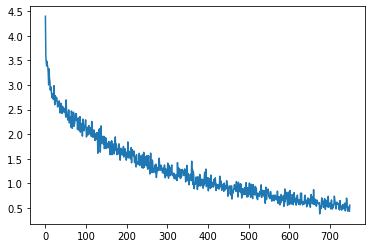

In [20]:
input_size = input_lang.n_words
embedding_dim = 100
hidden_dim = 256
n_layers = 1 
output_size = output_lang.n_words

encoder = EncoderRNN(input_size, hidden_dim).to(device)
decoder = AttnDecoderRNN(hidden_dim, output_size).to(device)

n_iters = 75000
print_every = 1000
trainIters(encoder, decoder, n_iters, print_every)

In [0]:
torch.save(encoder.state_dict(), 'enc_model.pt')
torch.save(decoder.state_dict(), 'dec_model.pt')

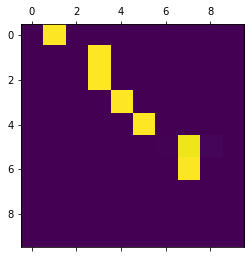

In [24]:
output, attentions = evaluate(encoder, decoder, "vous etes un petit menteur .")
plt.matshow(attentions.numpy())

In [0]:
def showAttention(attentions, input, output):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions.numpy(), cmap="gray")
  fig.colorbar(cax)

  ax.set_xticklabels(['']+input.split(' ')+['<EOS>'], rotation=90)
  ax.set_yticklabels(['']+output)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


def evaluateAndShowAttention(n=3):
  for i in range(n):
    pair = random.choice(pairs)
    output, attentions = evaluate(encoder, decoder, pair[0])
    showAttention(attentions, pair[0], output)

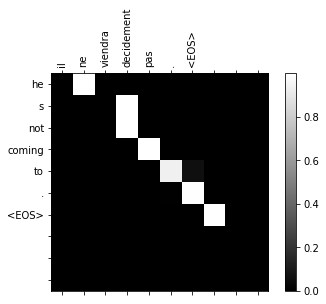

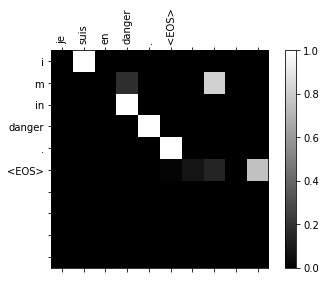

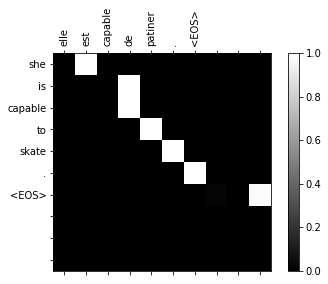

In [38]:
import matplotlib.ticker as ticker 


evaluateAndShowAttention()
